# Imports

In [41]:
from collections import Counter, defaultdict
import community as community_louvain
from expand import process_flight_sequences
from IPython.display import display, HTML
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
from pyvis.network import Network
import sqlite3

# Functions definition

In [42]:
def get_ngrams(sequence, n):
    """Generates n-grams from a list sequence efficiently."""
    if n == 0:
        return []
    # Using zip to create sliding windows is efficient in Python
    return zip(*[sequence[i:] for i in range(n)])


def find_significant_motifs(flights_data, k, z_threshold=1.96, nb_phases=None):
    """
    Identifies statistically significant k-motifs.
    
    Args:
        flights_data (list of lists): Each inner list is a sequence of flight phase integers.
        k (int): The length of the motif to analyze (e.g., 3).
        z_threshold (float): Z-score cutoff (1.96 for 95% confidence).
        nb_phases (int, optional): Number of unique flight phases (required for k=2).
        
    Returns:
        pd.DataFrame: Table of motifs with Obs/Exp probabilities and Z-scores.
    """
    if k == 2 and nb_phases is None:
        raise ValueError("For k=2, nb_phases must be provided to calculate expected probabilities.")
    
    # 1. Count frequencies for k, k-1, and k-2 patterns
    # We use a single pass over the data to populate all counters
    counts_k = Counter()      # Counts for x_1...x_k
    counts_prefix = Counter() # Counts for x_1...x_{k-1}
    counts_overlap = Counter() # Counts for x_2...x_{k-1} (the middle part)
    
    for flight in flights_data:
        # flight is a list of ints, e.g., [10, 20, 30, 40]
        if len(flight) < k:
            continue

        # Count k-grams (x_1...x_k)
        ngrams = list(get_ngrams(flight, k))
        counts_k.update(ngrams)
            
        # Note: If k=2, p_exp = p_obs (Eq. 5)
        if k > 2:
            # Count (k-1)-grams (used for prefix and suffix)
            ngrams_minus_1 = list(get_ngrams(flight, k - 1))
            counts_prefix.update(ngrams_minus_1)

            # Count (k-2)-grams (used for overlap)
            ngrams_minus_2 = list(get_ngrams(flight, k - 2))
            counts_overlap.update(ngrams_minus_2)
    
    # Track total number of substrings of each length for probability normalization
    total_k = counts_k.total()
    total_prefix = counts_prefix.total()
    total_overlap = counts_overlap.total()
    
    # 2. Calculate Probabilities and Z-scores
    results = []
    
    for motif, count in counts_k.items():
        if k == 2:
            # Observed Probability: p_obs(ABC)
            p_obs = count / total_k

            # Expected Probability: p_exp(AB) = poss(AB) / poss(XX)
            p_exp = 1 / nb_phases**2
            expected_count = (total_k/2) * p_exp  # Total possible pairs is total_k/2

            # Standard Deviation for binomial distribution approx: sqrt(N * p * (1-p))
            sigma = math.sqrt((total_k/2) * p_exp * (1 - p_exp))

        else:
            # Define parts of the motif
            # motif is a tuple like (A, B, C)
            prefix = motif[:-1]      # (A, B)
            suffix = motif[1:]       # (B, C)
            overlap = motif[1:-1]    # (B)

            # Observed Probability: p_obs(ABC)
            p_obs = count / total_k
            
            # Expected Probability calculation 
            # p_exp(ABC) = p_obs(AB) * p_obs(BC) / p_obs(B)
            prob_prefix = counts_prefix[prefix] / total_prefix
            prob_suffix = counts_prefix[suffix] / total_prefix

            prob_overlap = counts_overlap[overlap] / total_overlap
            if prob_overlap == 0:
                continue # Avoid division by zero
            p_exp = (prob_prefix * prob_suffix) / prob_overlap
            
            # Standard Deviation for binomial distribution approx: sqrt(N * p * (1-p))
            expected_count = p_exp * total_k
            sigma = math.sqrt(total_k * p_exp * (1 - p_exp))
        
        # Calculate Z-score
        if sigma == 0:
            z_score = 0 # p_exp is too small (prevent floating point issues)
        else:
            z_score = (count - expected_count) / sigma

        if z_score > z_threshold:
            results.append({
                "motif": motif,
                "count": count,
                "expected_count": expected_count,
                "p_obs": p_obs,
                "p_exp": p_exp,
                "z_score": z_score
            })
            
    # 3. Format Output
    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values(by="z_score", ascending=False)
    
    return df


def build_motif_edgelist(flights_data, significant_motifs_df, k, z_threshold=1.96):
    """
    Constructs the weighted network efficiently using sparse logic.
    Returns an Edge List DataFrame instead of a dense matrix.
    """
    
    # 1. Setup Nodes and Indices
    # Filter only significant motifs
    valid_motifs = significant_motifs_df['motif'].tolist()
    # Map motif tuple -> integer ID for efficient processing
    motif_to_idx = {motif: i for i, motif in enumerate(valid_motifs)}
    # Map integer ID -> probability (for vectorization later)
    motif_probs_dict = significant_motifs_df.set_index('motif')['p_obs'].to_dict()
    prob_array = np.array([motif_probs_dict[m] for m in valid_motifs])
    
    # 2. Pre-calculate Normalization Constant (Eq. 6 sum)
    normalization_sum = 0
    # We can calculate this purely from lengths, no need to load data content
    for flight in flights_data:
        l_s = len(flight)
        if l_s >= 2 * k:
            normalization_sum += (l_s - 2 * k + 1) * (l_s - 2 * k + 2)

    # 3. Sparse Counting of Observed Co-occurrences
    # We use a dict to sparsely store counts: {(source_idx, target_idx): count}
    observed_counts = defaultdict(int)
    
    for flight in flights_data:
        if len(flight) < 2 * k:
            continue
            
        # Find instances of significant motifs
        instances = []
        for i in range(len(flight) - k + 1):
            segment = tuple(flight[i : i+k])
            if segment in motif_to_idx:
                instances.append((i, motif_to_idx[segment]))
        
        # Count pairs (Time Complexity: O(M^2) where M is motifs per flight)
        # Since M is usually small compared to total motifs, this is fast.
        n_inst = len(instances)
        for i in range(n_inst):
            start_x, id_x = instances[i]
            for j in range(i + 1, n_inst):
                start_y, id_y = instances[j]
                
                # Check non-overlapping constraint
                if start_y >= start_x + k:
                    observed_counts[(id_x, id_y)] += 1

    # 4. Vectorized Z-Score Calculation (Only on observed edges)
    # Convert dict to arrays for numpy speed
    if not observed_counts:
        return pd.DataFrame(columns=['Source', 'Target', 'Weight'])

    sources = []
    targets = []
    counts = []
    
    for (u, v), c in observed_counts.items():
        sources.append(u)
        targets.append(v)
        counts.append(c)
    
    sources = np.array(sources)
    targets = np.array(targets)
    obs_counts = np.array(counts)
    
    # Calculate Expected Counts Vectorized
    # Exp(X, Y) = 0.5 * p(X) * p(Y) * normalization_sum
    # We fetch p(X) and p(Y) using the source/target indices
    p_source = prob_array[sources]
    p_target = prob_array[targets]
    
    expected_counts = 0.5 * p_source * p_target * normalization_sum
    
    # Calculate Z-scores
    # Using Poisson approximation for standard deviation: sigma = sqrt(expected)
    # For stricter binomial sigma, we'd need Total Possible Pairs, 
    # but sqrt(exp) is standard for rare network events.
    sigma = np.sqrt(expected_counts)
    
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        z_scores = (obs_counts - expected_counts) / sigma
        # Handle cases where sigma might be 0 (though unlikely if p > 0)
        z_scores = np.nan_to_num(z_scores)

    # 5. Filter and Format Output
    # Create mask for significant edges
    mask = z_scores > z_threshold
    
    # Map integer IDs back to Motif Tuples
    final_sources = [valid_motifs[i] for i in sources[mask]]
    final_targets = [valid_motifs[i] for i in targets[mask]]
    final_weights = z_scores[mask]
    
    # Create Edge List DataFrame
    edge_df = pd.DataFrame({
        'Source': final_sources,
        'Target': final_targets,
        'Weight': final_weights
    })
    
    # Sort by significance
    edge_df = edge_df.sort_values(by='Weight', ascending=False)
    
    return edge_df


def plot_static_graph(G):
    plt.figure(figsize=(12, 12))
    
    # 1. Calculate Layout (Spring layout positions nodes based on connections)
    pos = nx.spring_layout(G, k=0.5, seed=42)  # k regulates distance between nodes
    
    # 2. Extract Weights for styling
    weights = [G[u][v]['Weight'] for u, v in G.edges()]
    
    # Normalize weights for visualization (e.g., thickness between 0.5 and 4.5)
    # Avoid division by zero if all weights are same
    if max(weights) > min(weights):
        width = [(w - min(weights))/(max(weights)-min(weights)) * 4 + 0.5 for w in weights]
    else:
        width = [1.0 for _ in weights]

    # 3. Draw the Network
    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    
    # Edges (Width varies by Z-score)
    nx.draw_networkx_edges(G, pos, width=width, edge_color='gray', 
                           arrowstyle='->', arrowsize=20)
    
    # Labels (Motif names)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    
    plt.title("Flight Phase K-Motif Network (Weighted by Z-Score)")
    plt.axis('off')
    plt.show()


def plot_interactive_graph(G, filename="motif_network.html"):
    # Initialize PyVis network
    net = Network(height="750px", width="100%", notebook=False, cdn_resources='remote', directed=True)
    
    # Optional: Detect Communities (Louvain method) to color nodes
    try:
        partition = community_louvain.best_partition(G.to_undirected())
        # Add partition info to node attributes for coloring
        for node, group_id in partition.items():
            G.nodes[node]['group'] = group_id
    except ImportError:
        print("Community detection skipped (install 'python-louvain' for colors)")

    # Convert NetworkX graph to PyVis
    net.from_nx(G)
    
    # Customizing physics for better separation (optional)
    # net.set_options("""
    # var options = {
    #   "physics": {
    #     "forceAtlas2Based": {
    #       "gravitationalConstant": -50,
    #       "centralGravity": 0.01,
    #       "springLength": 100,
    #       "springConstant": 0.08
    #     },
    #     "maxVelocity": 50,
    #     "solver": "forceAtlas2Based",
    #     "timestep": 0.35,
    #     "stabilization": { "enabled": true }
    #   }
    # }
    # """)

    # Optional: Add physics controls (makes it fun to play with)
    net.show_buttons(filter_=['physics'])
    
    # Save the HTML file
    # Note: net.show() writes the file and attempts to display it, 
    # but IFrame is often more reliable for inline viewing.
    net.write_html(filename)
    
    # FALLBACK: Read the file content and embed it directly
    html_content = open(filename, 'r', encoding='utf-8').read()
    return display(HTML(html_content))


In [3]:
def build_motif_edgelist_lazy(flights_generator, significant_motifs_df, k, output_csv, z_threshold=1.96, db_path='temp_edges.db'):
    """
    Constructs the weighted network with minimal RAM usage by offloading 
    counts to a temporary SQLite database.
    
    Args:
        flights_generator: A generator yielding one sequence (list/string) at a time.
        significant_motifs_df: DataFrame containing 'motif' and 'p_obs'.
        k: Motif length.
        output_csv: Path to save the final Edge List.
        z_threshold: Z-score cutoff.
        db_path: Path for temporary SQL database (deleted after use).
    """
    
    # --- 1. Setup & Indexing ---
    print("Setting up indices...")
    valid_motifs = significant_motifs_df['motif'].tolist()
    motif_to_idx = {motif: i for i, motif in enumerate(valid_motifs)}
    
    # Map ID -> Probability for Z-score calc
    # We use a simple list where index matches ID for O(1) access
    prob_array = np.zeros(len(valid_motifs))
    motif_probs = significant_motifs_df.set_index('motif')['p_obs'].to_dict()
    for m, idx in motif_to_idx.items():
        prob_array[idx] = motif_probs[m]
        
    # --- 2. Initialize Temporary Database ---
    if os.path.exists(db_path):
        os.remove(db_path)
        
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    
    # Create a table to store edge counts.
    # We use (source, target) as primary key to handle summing efficiently.
    c.execute('''
        CREATE TABLE IF NOT EXISTS edge_counts (
            source INTEGER, 
            target INTEGER, 
            count INTEGER,
            PRIMARY KEY (source, target)
        )
    ''')
    # Speed up inserts
    c.execute('PRAGMA synchronous = OFF')
    c.execute('PRAGMA journal_mode = MEMORY') 
    
    # --- 3. Stream Processing & Counting ---
    print("Streaming flights and counting pairs to disk...")
    
    normalization_sum = 0
    buffer = {}  # Small in-memory buffer to reduce disk I/O
    BUFFER_SIZE = 1_000_000  # Number of pairs to hold before flushing to DB
    
    processed_count = 0
    
    for flight in flights_generator:
        l_s = len(flight)
        
        # Aggregate normalization sum (Eq. 6 in paper) 
        if l_s >= 2 * k:
            normalization_sum += (l_s - 2 * k + 1) * (l_s - 2 * k + 2)
        
        if l_s < 2 * k:
            continue
            
        # Identify instances of motifs
        instances = []
        for i in range(len(flight) - k + 1):
            segment = tuple(flight[i : i+k])
            if segment in motif_to_idx:
                instances.append((i, motif_to_idx[segment]))
        
        # Count non-overlapping co-occurrences [cite: 76]
        n_inst = len(instances)
        for i in range(n_inst):
            start_x, id_x = instances[i]
            for j in range(i + 1, n_inst):
                start_y, id_y = instances[j]
                
                # Check non-overlapping constraint
                if start_y >= start_x + k:
                    pair = (id_x, id_y)
                    buffer[pair] = buffer.get(pair, 0) + 1
        
        # Flush buffer to SQL if full
        if len(buffer) >= BUFFER_SIZE:
            _flush_buffer_to_db(c, buffer)
            buffer = {} # Reset buffer
            conn.commit()
            print(f"Processed {processed_count} flights...", end='\r')
            
        processed_count += 1

    # Final flush
    if buffer:
        _flush_buffer_to_db(c, buffer)
        conn.commit()
    
    print(f"\nFinished counting. Normalization Sum: {normalization_sum:.2e}")
    
    # --- 4. Compute Z-Scores and Write CSV ---
    print("Calculating Z-scores and writing to CSV...")
    
    # Prepare CSV header
    with open(output_csv, 'w') as f:
        f.write("Source,Target,Obs_count,Exp_count,Weight\n")
        
        # Stream results from DB so we never load the whole edge list
        # We perform Z-score calculation row-by-row here
        c.execute('SELECT source, target, count FROM edge_counts')
        
        while True:
            # Fetch in chunks to keep memory low
            rows = c.fetchmany(10000)
            if not rows:
                break
            
            # Vectorize this small chunk
            data = np.array(rows)
            sources = data[:, 0].astype(int)
            targets = data[:, 1].astype(int)
            obs_counts = data[:, 2]
            
            # Retrieve probabilities
            p_source = prob_array[sources]
            p_target = prob_array[targets]
            
            # Calculate Expected Counts (Eq. 6) 
            # N_exp = 0.5 * p(X) * p(Y) * NormSum
            expected_counts = 0.5 * p_source * p_target * normalization_sum
            
            # Calculate Sigma (Poisson approx)
            sigma = np.sqrt(expected_counts)
            
            # Calculate Z-score
            with np.errstate(divide='ignore', invalid='ignore'):
                z_scores = (obs_counts - expected_counts) / sigma
                z_scores = np.nan_to_num(z_scores)
            
            # Filter and Write
            mask = z_scores > z_threshold
            
            if np.any(mask):
                valid_indices = np.where(mask)[0]
                for idx in valid_indices:
                    src_name = str(valid_motifs[sources[idx]])
                    tgt_name = str(valid_motifs[targets[idx]])
                    obs_count = obs_counts[idx]
                    exp_count = expected_counts[idx]
                    weight = f"{z_scores[idx]:.4f}"
                    
                    # Write line immediately
                    f.write(f'"{src_name}","{tgt_name}",{obs_count},{exp_count},{weight}\n')

    # Cleanup
    conn.close()
    if os.path.exists(db_path):
        os.remove(db_path)
    print("Done.")

def _flush_buffer_to_db(cursor, buffer_dict):
    """
    Helper to upsert counts into SQLite.
    UPSERT syntax (ON CONFLICT DO UPDATE) requires SQLite 3.24+.
    For older python versions, we use standard INSERT with grouping later or helper logic.
    Here assumes modern SQLite or standard replacement logic.
    """
    # Convert dict items to list of tuples for executemany
    # items: [(source, target, count), ...]
    data = [(k[0], k[1], v) for k, v in buffer_dict.items()]
    
    # Upsert Query
    query = '''
        INSERT INTO edge_counts (source, target, count) 
        VALUES (?, ?, ?) 
        ON CONFLICT(source, target) 
        DO UPDATE SET count = count + excluded.count
    '''
    cursor.executemany(query, data)

In [ ]:
# If needed:
def file_stream_generator(file_path):
    """
    Opens a file and yields one line at a time.
    RAM usage: Length of 1 line (negligible).
    """
    with open(file_path, 'r') as f:
        # Determine if there's a header to skip
        # next(f) 
        
        for line in f:
            # Strip whitespace/newlines and split if necessary
            # Example: "A,B,C,D" -> ['A', 'B', 'C', 'D']
            flight_sequence = line.strip().split(',') 
            yield flight_sequence

# # Usage
# gen = file_stream_generator("large_flights_data.txt")
# build_motif_edgelist_lazy(gen, ...)

# Run

In [4]:
df = pd.read_csv("PIE_data_with_context.csv", sep=";", header=0, index_col=0)
df.drop(columns=['session'], inplace=True)
df = df.sort_values(by=['F_SESSION', 'F_START_FRAME'], ascending=[True, True])
df.head()

,F_SESSION,F_START_FRAME,F_END_FRAME,F_DURATION,FIRST_WORD_INDEX,SECOND_WORD_INDEX,THIRD_WORD_INDEX,k_aircraft,k_operator,k_mission
879696,3130311,332,375,00:00:22.000,3.0,10.0,285.0,46852,20,-2
879697,3130311,376,441,00:00:33.000,3.0,75.0,281.0,46852,20,-2
879698,3130311,442,741,00:02:30.000,3.0,10.0,8.0,46852,20,-2
879699,3130311,742,760,00:00:09.500,3.0,28.0,39.0,46852,20,-2
879700,3130311,761,764,00:00:02.000,3.0,10.0,8.0,46852,20,-2


In [5]:
first = df['FIRST_WORD_INDEX']
second = df['SECOND_WORD_INDEX']
third = df['THIRD_WORD_INDEX']

df['phase'] = list(zip(first, second, third))
phase_to_idx = {phase: i for i, phase in enumerate(df['phase'].unique())}
idx_to_phase = {i: phase for i, phase in enumerate(df['phase'].unique())}
df['phase_idx'] = df['phase'].map(phase_to_idx)
df.head()

,F_SESSION,F_START_FRAME,F_END_FRAME,F_DURATION,FIRST_WORD_INDEX,SECOND_WORD_INDEX,THIRD_WORD_INDEX,k_aircraft,k_operator,k_mission,phase,phase_idx
879696,3130311,332,375,00:00:22.000,3.0,10.0,285.0,46852,20,-2,"(3.0, 10.0, 285.0)",0
879697,3130311,376,441,00:00:33.000,3.0,75.0,281.0,46852,20,-2,"(3.0, 75.0, 281.0)",1
879698,3130311,442,741,00:02:30.000,3.0,10.0,8.0,46852,20,-2,"(3.0, 10.0, 8.0)",2
879699,3130311,742,760,00:00:09.500,3.0,28.0,39.0,46852,20,-2,"(3.0, 28.0, 39.0)",3
879700,3130311,761,764,00:00:02.000,3.0,10.0,8.0,46852,20,-2,"(3.0, 10.0, 8.0)",2


In [6]:
df.drop(columns=['phase', 'FIRST_WORD_INDEX', 'SECOND_WORD_INDEX', 'THIRD_WORD_INDEX', 'F_START_FRAME', 'F_END_FRAME'], inplace=True)
sessions = df['F_SESSION'].unique()

md = 1

# df = process_flight_sequences(df, md=1)
df['F_DURATION'] = pd.to_timedelta(df['F_DURATION'])
df['duration_sec'] = df['F_DURATION'].dt.total_seconds()
df['reps'] = np.ceil(df['duration_sec'] / md).astype(int)

df.drop(columns=['F_DURATION', 'duration_sec'], inplace=True)
df = df.loc[df.index.repeat(df['reps'])].copy()
df.drop(columns=['reps'], inplace=True)

df.head()

,F_SESSION,k_aircraft,k_operator,k_mission,phase_idx
879696,3130311,46852,20,-2,0
879696,3130311,46852,20,-2,0
879696,3130311,46852,20,-2,0
879696,3130311,46852,20,-2,0
879696,3130311,46852,20,-2,0


In [7]:
flights = [df[df['F_SESSION'] == s]['phase_idx'].to_list() for s in sessions]

In [8]:
k = 3
df_significant = find_significant_motifs(flights, k, z_threshold=1.96, nb_phases=None)
print(f"Total significant motifs found: {len(df_significant)}")
df_significant.sort_values(by="z_score", ascending=False)

Total significant motifs found: 440776


,motif,count,expected_count,p_obs,p_exp,z_score
369404,"(966, 7, 5402)",1,0.000005,6.362129e-08,3.087423e-13,453.942731
150675,"(6, 4, 3189)",1,0.000007,6.362129e-08,4.144844e-13,391.781830
39110,"(17953, 1124, 1099)",1,0.000011,6.362129e-08,6.979156e-13,301.922177
228236,"(7606, 1523, 7184)",1,0.000028,6.362129e-08,1.780912e-12,189.002647
34340,"(17242, 892, 16029)",1,0.000029,6.362129e-08,1.826518e-12,186.627974
...,...,...,...,...,...,...
175598,"(3265, 723, 8671)",1,0.176498,6.362129e-08,1.122904e-08,1.960173
157427,"(1365, 2813, 1348)",2,0.548409,1.272426e-07,3.489048e-08,1.960162
66083,"(3265, 723, 8223)",5,2.135628,3.181064e-07,1.358714e-07,1.960048
329741,"(6837, 7993, 8390)",3,1.020243,1.908639e-07,6.490917e-08,1.960018


In [9]:
df_significant[df_significant['count']>1]

,motif,count,expected_count,p_obs,p_exp,z_score
180,"(5, 2, 5)",528,10.760936,3.359204e-05,6.846246e-07,157.676305
376679,"(1096, 1368, 2815)",2,0.000176,1.272426e-07,1.120438e-11,150.695058
53,"(116, 7, 116)",1241,64.875214,7.895402e-05,4.127445e-06,146.020859
23637,"(1139, 2810, 3276)",2,0.000200,1.272426e-07,1.270140e-11,141.534450
307,"(3, 2, 3)",407,10.142641,2.589386e-05,6.452879e-07,124.611768
...,...,...,...,...,...,...
79220,"(4162, 4999, 1595)",3,1.020161,1.908639e-07,6.490398e-08,1.960178
157427,"(1365, 2813, 1348)",2,0.548409,1.272426e-07,3.489048e-08,1.960162
66083,"(3265, 723, 8223)",5,2.135628,3.181064e-07,1.358714e-07,1.960048
329741,"(6837, 7993, 8390)",3,1.020243,1.908639e-07,6.490917e-08,1.960018


In [ ]:
def flight_data_stream(flights_list):
    for flight in flights_list:
        yield flight

df_significant = df_significant[df_significant['count']>1]

In [11]:
build_motif_edgelist_lazy(
    flights_generator=flight_data_stream(flights), 
    significant_motifs_df=df_significant, 
    k=3, 
    output_csv="final_network.csv"
)

Setting up indices...
Streaming flights and counting pairs to disk...
Processed 1740 flights...
Finished counting. Normalization Sum: 1.53e+11
Calculating Z-scores and writing to CSV...
Done.


In [13]:
df = pd.read_csv("final_network.csv")
df.head()

,Source,Target,Obs_count,Exp_count,Weight
0,"(3, 3, 2)","(7, 7, 7)",219994,213074.404226,14.9905
1,"(3, 3, 2)","(116, 116, 116)",54598,49834.404353,21.3388
2,"(3, 3, 2)","(116, 7, 116)",1614,1444.323683,4.4647
3,"(3, 3, 2)","(128, 128, 128)",902,641.275060,10.2958
4,"(3, 3, 2)","(189, 190, 190)",5890,4833.421642,15.1976


In [17]:
len(df[df['Obs_count']>5])

2400459

In [18]:
print(f"Total edges in final network: {len(df)}")
print(f"Total nodes in final network: {len(set(df['Source']).union(set(df['Target'])))}")

Total edges in final network: 14444274
Total nodes in final network: 52850


In [19]:
def visualize_top_edges(csv_path, top_n=1000):
    """
    Loads the graph but keeps only the top N strongest edges for clear visualization.
    """
    # Load data
    df = pd.read_csv(csv_path)
    
    # Sort by Weight (Z-score) descending and take top N
    df_top = df.sort_values(by='Weight', ascending=False).head(top_n)
    df_top.reset_index(drop=True, inplace=True)
    df_top.drop(columns=['Obs_count', 'Exp_count'], inplace=True)
    
    # Create smaller graph for visualization
    G_viz = nx.from_pandas_edgelist(
        df_top, 
        source='Source', 
        target='Target', 
        edge_attr='Weight', 
        create_using=nx.DiGraph
    )
    
    print(f"Visualizing top {top_n} edges out of {len(df)} total significant edges.")
    return G_viz

# Usage
G = visualize_top_edges("final_network.csv", top_n=2000)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Visualizing top 2000 edges out of 14444274 total significant edges.
Nodes: 493, Edges: 2000


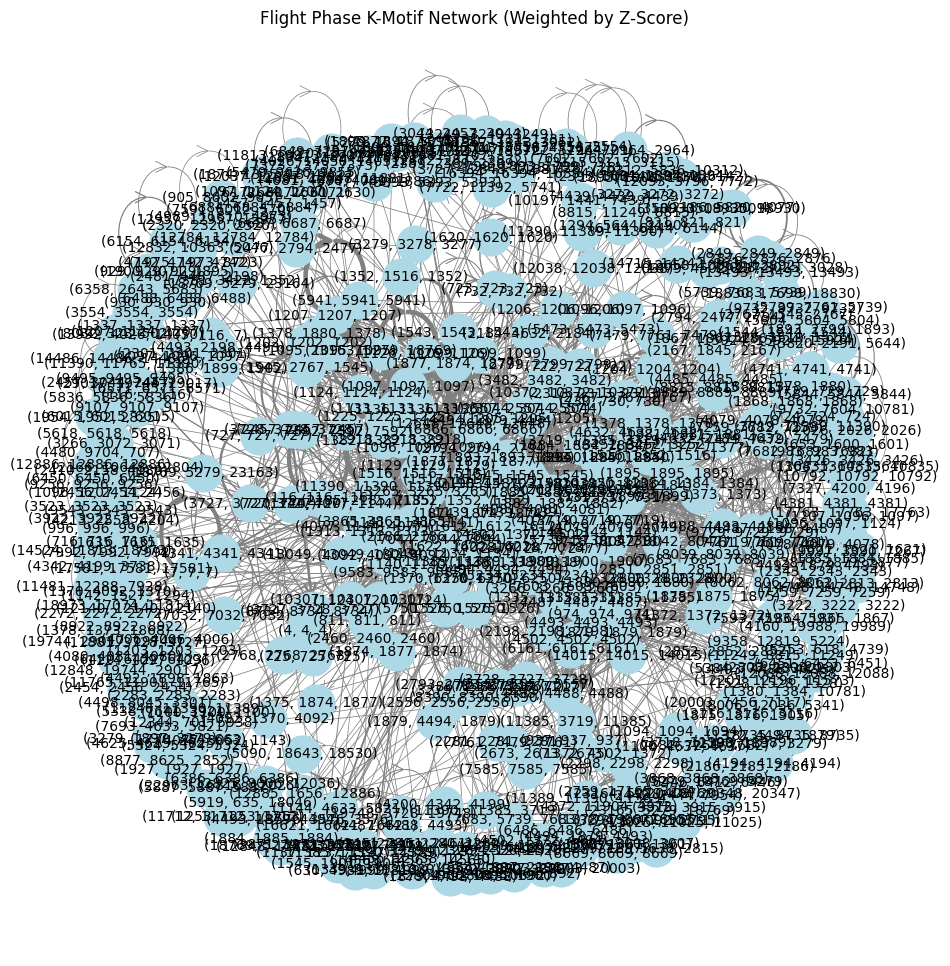

In [22]:
plot_static_graph(G)